- Image scale normalization
- blurring ✅
- merging?

In [3]:
import matplotlib.image as mimg
import matplotlib.pyplot as plt
import numpy as np

In [88]:
img1 = mimg.imread('Input Images/Spiral.jpg')
img2 = mimg.imread('Input Images/Oogway_forest.jpg')

In [125]:
# other functions

# overlay dependency
def avg_pixel_weighted(channel_val1, weight1, channel_val2, weight2):
    adjusted_weight_total = weight1 + weight2
    return ( (channel_val1 * weight1 + channel_val2 * weight2)/adjusted_weight_total)


# blur dependency
def avg_color_grid(img, blur_size, start_pixel):

    r_total, g_total, b_total=0, 0, 0
    x_dim, y_dim = start_pixel
    counter = blur_size**2

    for i in range(blur_size):
        for j in range(blur_size):

            r_total += img.item((x_dim + i, y_dim + j, 0))
            g_total += img.item((x_dim + i, y_dim + j, 1))
            b_total += img.item((x_dim + i, y_dim + j, 2))

    return np.array((r_total / counter, g_total / counter, b_total / counter))


In [126]:
# 2 image processing

def overlay(img1, img2):
    IMG1_WEIGHT = 1
    IMG2_WEIGHT = 1
    
    max_x_size = max(img1.shape[0], img2.shape[0])
    max_y_size = max(img1.shape[1], img2.shape[1])

    new_img_arr = np.empty((max_x_size, max_y_size, 3))

    for i in range(max_x_size):
        for j in range(max_y_size):
            for k in range(3):

                new_img_arr[i, j, k] = avg_pixel_weighted(img1.item((i, j, k)), IMG1_WEIGHT, img2.item((i, j, k)), IMG2_WEIGHT) / 255  # 4 sec

    return new_img_arr


In [127]:
# 1 image processing

def blur(img):
    # blur_size = int(input("Blur size: "))
    blur_size = 2
    # 2 - 17.8s
    # 3 - 24.6s
    # 5 - ~47s
    # 10 - 2m 37.5s

    height = img.shape[0]
    width = img.shape[1]

    new_img_arr = np.empty((img.shape[0], img.shape[1], 3))

    for i in range(height - blur_size):
        for j in range(width - blur_size):
            new_img_arr[i, j] = avg_color_grid(img, blur_size, (i, j)) / 255

    return new_img_arr


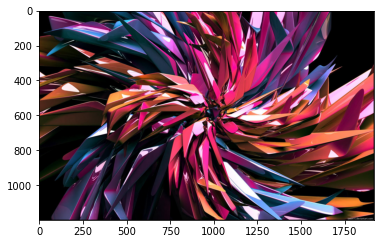

In [128]:
plt.imshow(blur(img1))
# plt.imsave("Output Images/Overlay/Overlay1-1.jpg", overlay(img1, img2))